In [1]:
import pandas as pd
import joblib as pk
import numpy as np

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
X_train = pd.read_table("/home/juanrafaelvalera@vhio.org/ondemand/CARE/data/data_train.tsv")
df = X_train


In [2]:

## DATA
# Filtering variables with too many missing values
na_frac = df.drop(columns=["risk_status", "dfs_status", "dfs_time"]).isna().mean()
keep = na_frac[na_frac <= 0.10].index.tolist()
df = df.loc[:, keep + ["risk_status", "dfs_status", "dfs_time"]]

# Removing samples with any missing value
keep = df.drop(columns=["risk_status", "dfs_status", "dfs_time"]).dropna().index.tolist()
df = df.loc[keep, :]

print(f"Training with {df.shape[0]} samples")

y_class = df["risk_status"].copy()
y_event = df["dfs_status"].copy()
y_time = df["dfs_time"].copy()
X = df.drop(columns=["risk_status", "dfs_status", "dfs_time", "os_status"])

# Standard Scale numerical variables
scaler = StandardScaler()
cols = ["edad", "imc", "tamano_tumoral"]
X[cols] = scaler.fit_transform(X[cols])

X_class = X.loc[y_class.notna(), :]
y_class = y_class.loc[y_class.notna()]

X_surv = X.loc[(y_event.notna()) & (y_time.notna()), :]
y_time = y_time.loc[(y_event.notna()) & (y_time.notna())]
y_event = y_event.loc[(y_event.notna()) & (y_time.notna())]
y_surv = Surv.from_arrays(event=y_event.astype(bool), time=y_time)

Training with 121 samples


In [3]:

f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/class_logreg.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)
pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file
pipe.steps


[('scaler', StandardScaler()),
 ('selector', FCBFSelector(kbest=20, mode='rank')),
 ('model',
  LogisticRegression(C=7.196856730011514, l1_ratio=1.0, max_iter=5000,
                     penalty='elasticnet', solver='saga'))]

In [4]:

clf = pipe.named_steps["model"]          # LogisticRegression
coefs = clf.coef_.ravel()                # shape (n_selected,)
intercept = float(clf.intercept_.ravel()[0])

In [7]:
selector = pipe.named_steps["selector"]
X_cols = np.array(X_train.columns)
sels_cols = selector.selected_features_



In [38]:
selected_cols = X_train.columns[sel_cols]


In [43]:
coef_table = (
    pd.DataFrame({
        "feature": selected_cols,
        "coef_log_odds": coefs,
        "odds_ratio": np.exp(coefs),
        "abs_coef": np.abs(coefs),
    })
    .sort_values("abs_coef", ascending=False)
    .drop(columns="abs_coef")
)
top10_lr = coef_table[1:10]



In [11]:

f ="/home/juanrafaelvalera@vhio.org/ondemand/CARE/artifacts/models/class_svc.pkl"

with open(f, "rb") as a:
    
    object_file = pk.load(a)
pipe = object_file.best_estimator_ if hasattr(object_file, "best_estimator_") else object_file
svc = pipe.named_steps["model"]

In [12]:
selected_cols = X_train.columns[pipe.named_steps["selector"].selected_features_]
from sklearn.model_selection import train_test_split

# First split: hold out TEST
X_temp, X_test, y_temp, y_test = train_test_split(
    X_class, y_class, test_size=0.20, stratify=y_class, random_state=0
)

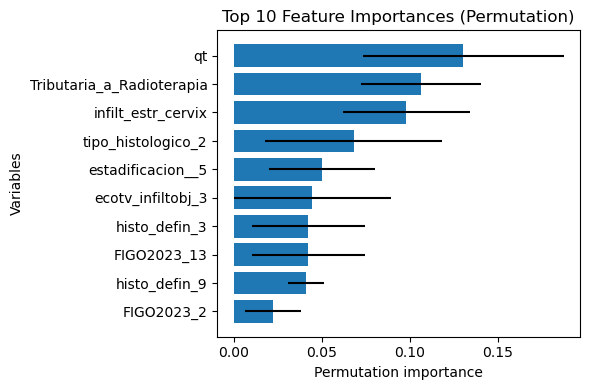

In [17]:

def permutation_importance_table(pipe, X_test, y_test, scoring="roc_auc",
                                 n_repeats=30, random_state=0):
    r = permutation_importance(
        pipe,
        X_test, y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=-1,
    )
    out = pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std,
    }).sort_values("importance_mean", ascending=False)
    return out



svc_perm = permutation_importance_table(pipe, X_test, y_test, scoring="roc_auc")


## Feature importance by model

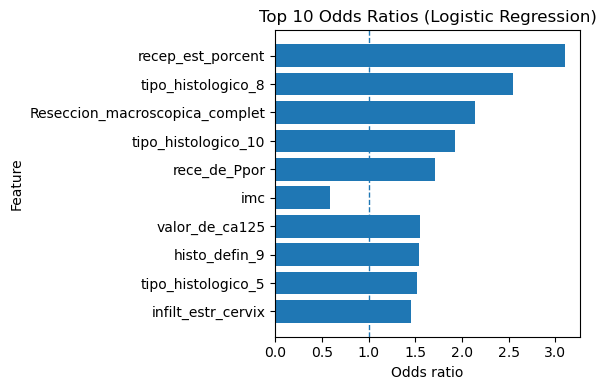

KeyError: 'importance_mean'

<Figure size 600x400 with 0 Axes>

In [44]:
top10_lr
plt.figure(figsize=(6, 4))
plt.barh(
    top10["feature"][::-1],
    top10["odds_ratio"][::-1],
)
plt.axvline(1, linestyle="--", linewidth=1)
plt.xlabel("Odds ratio")
plt.ylabel("Feature")
plt.title("Top 10 Odds Ratios (Logistic Regression)")
plt.tight_layout()
plt.show()


top10_sv= svc_perm.head(10)

plt.figure(figsize=(6, 4))
plt.barh(
    top10_sv["feature"][::-1],
    top10_sv["importance_mean"][::-1],
    xerr=top10["importance_std"][::-1]
)
plt.xlabel("Permutation importance")
plt.ylabel("Variables")
plt.title("Top 10 Feature Importances (Permutation)")
plt.tight_layout()
plt.show()
